In [1]:
# Core data science libraries
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Machine learning libraries
!pip install scikit-learn

# Natural language processing
!pip install nltk

# Text visualization
!pip install wordcloud

# Optional: If you want to suppress warnings more effectively
!pip install warnings

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
except:
    pass

print("TripTales Customer Review Sentiment Analysis")
print("=" * 45)

TripTales Customer Review Sentiment Analysis


In [3]:
# Step 1: Load Data
df = pd.read_csv('/content/Customer Review Sentiment Analysis for TripTales.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Dataset Shape: (1000, 6)
Columns: ['Customer ID', 'Location', 'Platform', 'Rating', 'Review Text', 'Sentiment']

First few rows:
  Customer ID Location Platform  Rating  \
0    CUST1000      Goa      App       2   
1    CUST1001      Goa      App       4   
2    CUST1002      Goa      App       1   
3    CUST1003   Mumbai      Web       5   
4    CUST1004      Goa      App       4   

                                         Review Text Sentiment  
0  stay room trip stay poor bad stay hotel locati...  Negative  
1  recommended recommended room trip recommended ...  Positive  
2  hotel hotel service stay hotel stay experience...  Negative  
3  amazing room hotel hotel experience fantastic ...  Positive  
4  experience stay hotel room fantastic room fant...  Positive  

Missing Values:
Customer ID    0
Location       0
Platform       0
Rating         0
Review Text    0
Sentiment      0
dtype: int64

Sentiment Distribution:
Sentiment
Positive    604
Neutral     199
Negative    197
Name: c

In [4]:
# Step 2: Text Preprocessing
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at'])

    def clean_text(self, text):
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        # Tokenize and remove stopwords
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

# Clean the text data
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['Review Text'].apply(preprocessor.clean_text)

# Remove empty texts
df = df[df['cleaned_text'].str.len() > 0]

print(f"After preprocessing: {df.shape}")



After preprocessing: (1000, 7)


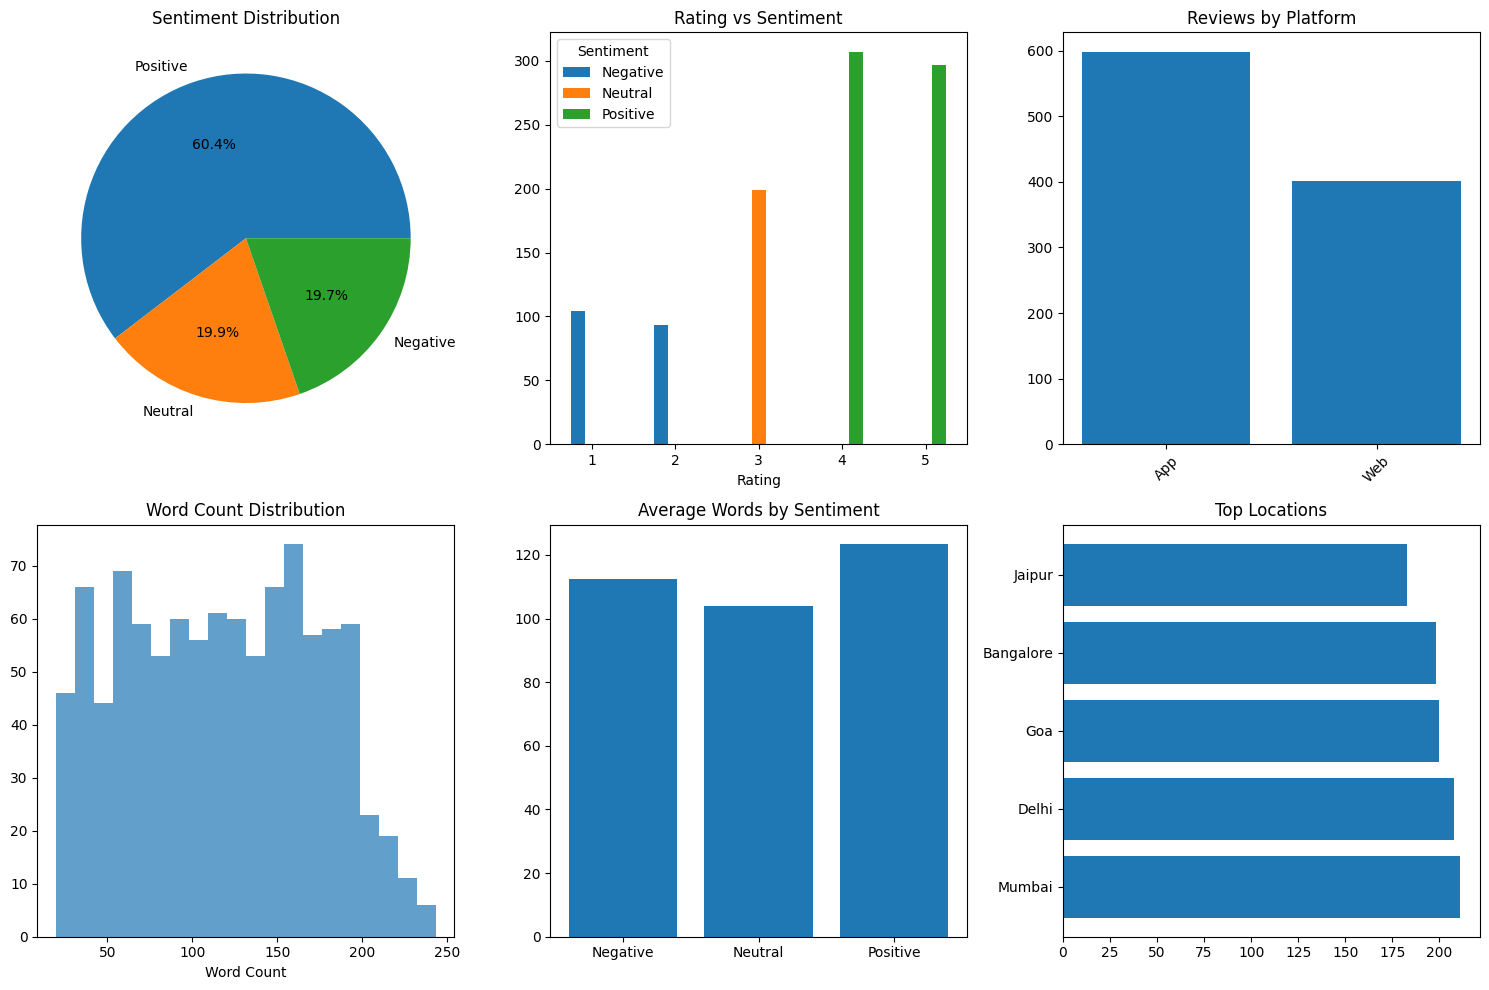

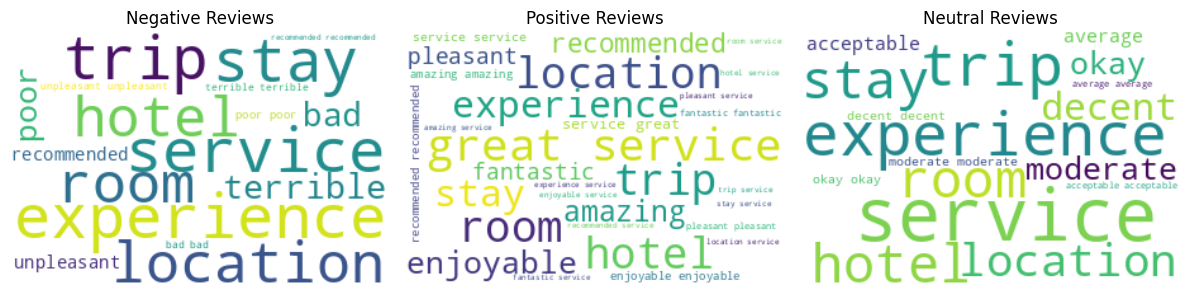

In [5]:
# Step 3: Basic Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Sentiment distribution
plt.subplot(2, 3, 1)
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

# Rating vs Sentiment
plt.subplot(2, 3, 2)
pd.crosstab(df['Rating'], df['Sentiment']).plot(kind='bar', ax=plt.gca())
plt.title('Rating vs Sentiment')
plt.xlabel('Rating')
plt.xticks(rotation=0)

# Platform distribution
plt.subplot(2, 3, 3)
platform_counts = df['Platform'].value_counts()
plt.bar(platform_counts.index, platform_counts.values)
plt.title('Reviews by Platform')
plt.xticks(rotation=45)

# Review length
plt.subplot(2, 3, 4)
df['word_count'] = df['cleaned_text'].str.split().str.len()
plt.hist(df['word_count'], bins=20, alpha=0.7)
plt.xlabel('Word Count')
plt.title('Word Count Distribution')

# Average words by sentiment
plt.subplot(2, 3, 5)
avg_words = df.groupby('Sentiment')['word_count'].mean()
plt.bar(avg_words.index, avg_words.values)
plt.title('Average Words by Sentiment')

# Top locations
plt.subplot(2, 3, 6)
top_locations = df['Location'].value_counts().head(8)
plt.barh(range(len(top_locations)), top_locations.values)
plt.yticks(range(len(top_locations)), top_locations.index)
plt.title('Top Locations')

plt.tight_layout()
plt.show()

# Word clouds
sentiments = df['Sentiment'].unique()
plt.figure(figsize=(12, 4))

for i, sentiment in enumerate(sentiments):
    plt.subplot(1, len(sentiments), i+1)
    text = ' '.join(df[df['Sentiment'] == sentiment]['cleaned_text'])
    if len(text) > 0:
        wordcloud = WordCloud(width=300, height=200, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{sentiment.title()} Reviews')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Step 4: Prepare Data for ML
# Encode sentiment labels
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['Sentiment'])

# Split data
X = df['cleaned_text']
y = df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Features created: {X_train_tfidf.shape[1]}")


Training set: 800
Test set: 200
Features created: 347


In [7]:
# Step 5: Train Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'accuracy': accuracy, 'predictions': y_pred}
    print(f"Accuracy: {accuracy:.4f}")



Training Logistic Regression...
Accuracy: 1.0000

Training Naive Bayes...
Accuracy: 1.0000

Training Random Forest...
Accuracy: 1.0000


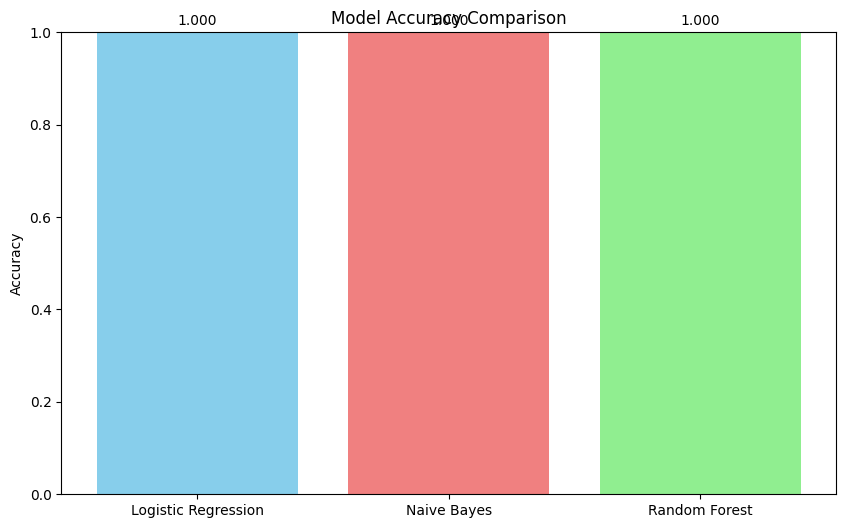


Best Model: Logistic Regression
Best Accuracy: 1.0000


In [8]:
# Step 6: Compare Models
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom')

plt.show()

# Best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_pred = results[best_model_name]['predictions']

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")



Classification Report - Logistic Regression:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        39
     Neutral       1.00      1.00      1.00        40
    Positive       1.00      1.00      1.00       121

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



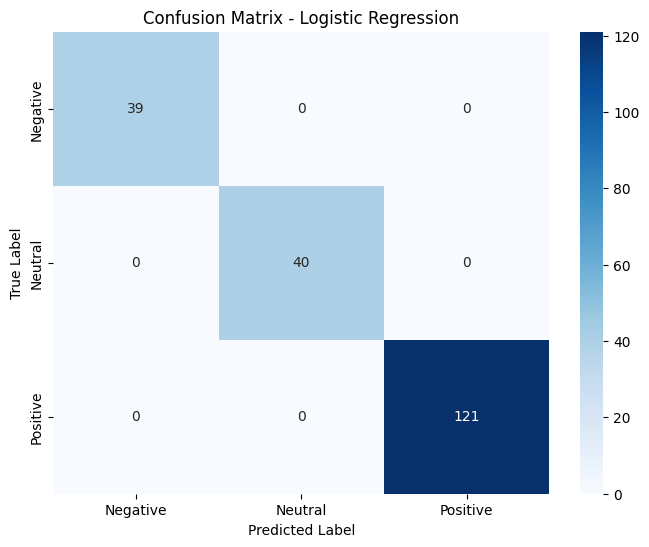

In [9]:
# Step 7: Detailed Evaluation
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, best_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

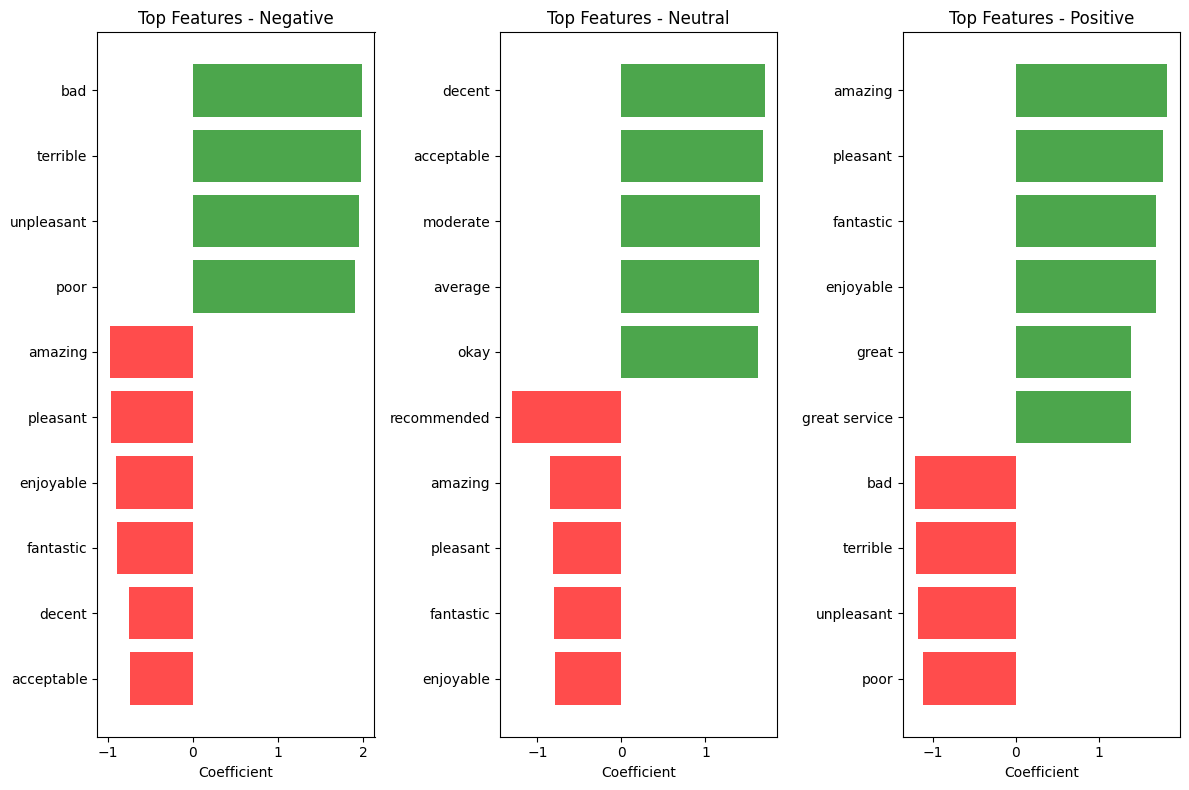

In [10]:
# Step 8: Feature Importance (for Logistic Regression)
if best_model_name == 'Logistic Regression':
    feature_names = vectorizer.get_feature_names_out()

    plt.figure(figsize=(12, 8))

    for i, class_name in enumerate(le.classes_):
        plt.subplot(1, len(le.classes_), i+1)

        if len(best_model.coef_) > 1:
            coeffs = best_model.coef_[i]
        else:
            coeffs = best_model.coef_[0] if i == 1 else -best_model.coef_[0]

        # Top 10 features
        top_indices = np.argsort(np.abs(coeffs))[-10:]
        top_features = [feature_names[idx] for idx in top_indices]
        top_coeffs = [coeffs[idx] for idx in top_indices]

        colors = ['red' if coeff < 0 else 'green' for coeff in top_coeffs]
        plt.barh(range(len(top_features)), top_coeffs, color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features)
        plt.title(f'Top Features - {class_name}')
        plt.xlabel('Coefficient')

    plt.tight_layout()
    plt.show()



In [11]:



# Step 9: Test with New Reviews
def predict_sentiment(text):
    cleaned = preprocessor.clean_text(text)
    features = vectorizer.transform([cleaned])
    prediction = best_model.predict(features)[0]
    return le.inverse_transform([prediction])[0]

test_reviews = [
    "Amazing hotel! Perfect location and excellent service.",
    "Terrible experience. Room was dirty and staff was rude.",
    "Average hotel, nothing special but decent for the price.",
    "Beautiful destination with great weather and friendly people."
]

print(f"\nTesting with sample reviews:")
print("-" * 40)
for review in test_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Predicted: {sentiment}\n")




Testing with sample reviews:
----------------------------------------
Review: Amazing hotel! Perfect location and excellent service.
Predicted: Positive

Review: Terrible experience. Room was dirty and staff was rude.
Predicted: Negative

Review: Average hotel, nothing special but decent for the price.
Predicted: Neutral

Review: Beautiful destination with great weather and friendly people.
Predicted: Positive



In [12]:
# Step 10: Business Insights
print(f"BUSINESS INSIGHTS:")
print("=" * 30)

total_reviews = len(df)
sentiment_counts = df['Sentiment'].value_counts()

print(f"\nOverall Performance:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / total_reviews) * 100
    print(f"  {sentiment}: {count} reviews ({percentage:.1f}%)")

print(f"\nPlatform Performance:")
platform_sentiment = df.groupby('Platform')['Sentiment'].apply(
    lambda x: (x == 'positive').mean() * 100
).round(1)
for platform, pos_pct in platform_sentiment.items():
    print(f"  {platform}: {pos_pct}% positive")

print(f"\nTop Performing Locations:")
location_sentiment = df.groupby('Location')['Sentiment'].apply(
    lambda x: (x == 'positive').mean() * 100
).round(1).sort_values(ascending=False)

for location, pos_pct in location_sentiment.head(5).items():
    review_count = df[df['Location'] == location].shape[0]
    if review_count >= 3:  # Only show locations with multiple reviews
        print(f"  {location}: {pos_pct}% positive ({review_count} reviews)")

print(f"\nRecommendations:")
negative_pct = (sentiment_counts.get('negative', 0) / total_reviews) * 100
if negative_pct > 25:
    print(f"  - High negative sentiment ({negative_pct:.1f}%) - investigate common issues")
if negative_pct < 15:
    print(f"  - Low negative sentiment ({negative_pct:.1f}%) - maintain current standards")

print(f"  - Monitor {platform_sentiment.idxmin()} platform performance")
print(f"  - Leverage success factors from {location_sentiment.index[0]}")

print(f"\nAnalysis Complete!")
print(f"Model trained and ready for sentiment classification.")

BUSINESS INSIGHTS:

Overall Performance:
  Positive: 604 reviews (60.4%)
  Neutral: 199 reviews (19.9%)
  Negative: 197 reviews (19.7%)

Platform Performance:
  App: 0.0% positive
  Web: 0.0% positive

Top Performing Locations:
  Bangalore: 0.0% positive (198 reviews)
  Delhi: 0.0% positive (208 reviews)
  Goa: 0.0% positive (200 reviews)
  Jaipur: 0.0% positive (183 reviews)
  Mumbai: 0.0% positive (211 reviews)

Recommendations:
  - Low negative sentiment (0.0%) - maintain current standards
  - Monitor App platform performance
  - Leverage success factors from Bangalore

Analysis Complete!
Model trained and ready for sentiment classification.
